In [16]:
import pandas as pd
import numpy as np

import os

%pylab inline

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

Populating the interactive namespace from numpy and matplotlib


C:\Users\Vince\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [35]:
data = pd.read_csv('Magic record - Sheet1.csv')

data.columns = 'Me Opponent Win Rank Hand Mulligans del1 del2'.split()

del data['Hand']
del data['Mulligans']
del data['del1']
del data['del2']

data.tail()

,Me,Opponent,Win,Rank
266,BG,WG,1,Silver 4
267,R,R,1,Silver 4
268,UBG,WU,0,Silver 4
269,UBG,BR,0,Silver 4
270,UBG,BR,1,Silver 4


In [36]:
# How many times I've played each color combo
data.groupby('Me').count().sort_values('Opponent', ascending=False)[['Opponent']]

,Opponent
Me,
BG,45
R,31
UR,30
WG,26
UB,25
UG,19
RG,18
G,13
BR,12


In [37]:
data['Me_W'] = np.where(data['Me'].str.contains('W'), 1, 0)
data['Me_U'] = np.where(data['Me'].str.contains('U'), 1, 0)
data['Me_B'] = np.where(data['Me'].str.contains('B'), 1, 0)
data['Me_R'] = np.where(data['Me'].str.contains('R'), 1, 0)
data['Me_G'] = np.where(data['Me'].str.contains('G'), 1, 0)

data['Opponent_W'] = np.where(data['Opponent'].str.contains('W'), 1, 0)
data['Opponent_U'] = np.where(data['Opponent'].str.contains('U'), 1, 0)
data['Opponent_B'] = np.where(data['Opponent'].str.contains('B'), 1, 0)
data['Opponent_R'] = np.where(data['Opponent'].str.contains('R'), 1, 0)
data['Opponent_G'] = np.where(data['Opponent'].str.contains('G'), 1, 0)

rank = np.where(data['Rank'] == 'Bronze 1', 1, np.nan)
rank = np.where(data['Rank'] == 'Silver 4', 2, rank)
rank = np.where(data['Rank'] == 'Silver 3', 3, rank)

data['My_colors_ct'] = data['Me'].apply(len)
data['Opponent_colors_ct'] = data['Opponent'].apply(len)

data['Rank'] = pd.Series(rank)

In [38]:
data.groupby('Me').mean()['Win'].sort_values()

Me
B      0.000000
W      0.000000
WUR    0.333333
UBR    0.363636
UR     0.366667
UG     0.421053
G      0.461538
WR     0.500000
BG     0.511111
WUB    0.600000
WB     0.600000
WG     0.653846
RG     0.666667
BR     0.666667
UB     0.680000
R      0.709677
UBG    0.714286
Name: Win, dtype: float64

In [39]:
data.groupby('Opponent').mean()['Win'].sort_values()

Opponent
UG       0.000000
RW       0.000000
WRG      0.000000
WBG      0.000000
RG       0.333333
UR       0.400000
BG       0.428571
W        0.437500
BR       0.478261
BRG      0.500000
WUB      0.500000
G        0.518519
R        0.525000
WU       0.533333
B        0.538462
UB       0.625000
UBR      0.636364
WB       0.666667
WR       0.666667
U        0.666667
UBG      0.750000
WUG      0.750000
WG       0.833333
UBRG     1.000000
WBR      1.000000
BW       1.000000
WUBG     1.000000
WUBRG    1.000000
WUR      1.000000
Name: Win, dtype: float64

In [40]:
del data['Me']
del data['Opponent']

data = pd.get_dummies(data)

In [41]:
x = data.drop('Win', axis=1).dropna(axis=1)
y = data['Win'].dropna()

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

clf = DecisionTreeClassifier()
kf = StratifiedKFold(n_splits=3)

param_grid = {
    'max_depth': np.arange(2,7),
    'min_samples_leaf': np.arange(1,13),
    'min_samples_split': np.arange(2,13),
    
}

grid = GridSearchCV(clf, param_grid, cv=kf, scoring='roc_auc').fit(x, y)
clf = grid.best_estimator_

clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [43]:
cv = cross_val_score(clf, x, y, cv=kf, scoring='roc_auc')

cv.mean(), cv.std()

(0.5203642142106553, 0.06829784825567288)

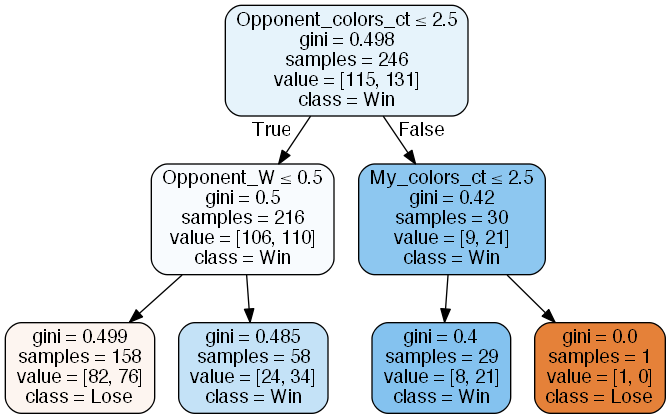

In [136]:
from sklearn.tree import export_graphviz

clf = DecisionTreeClassifier(max_depth=2)
clf = clf.fit(x,y)
from IPython.display import Image  
import pydotplus

dot_data = export_graphviz(clf, out_file=None, 
                         feature_names=x.columns,  
                         class_names=['Lose', 'Win'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

In [137]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

clf = LogisticRegression()
kf = StratifiedKFold()

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [.0001, .001, .01, .1, 1, 2, .5]
}

grid = GridSearchCV(clf, param_grid, cv=kf, scoring='roc_auc').fit(x, y)
clf = grid.best_estimator_

clf

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [138]:
cv = cross_val_score(clf, x, y, cv=kf, scoring='roc_auc')

cv.mean(), cv.std()

(0.5391826655596546, 0.04661474281869491)

In [115]:
pd.DataFrame(clf.coef_, columns=x.columns).T.sort_values(0)

,0
Me_W,0.0
Me_U,0.0
Me_B,0.0
Me_R,0.0
Me_G,0.0
Opponent_W,0.0
Opponent_U,0.0
Opponent_B,0.0
Opponent_R,0.0
Opponent_G,0.0


In [116]:
data.to_csv('record_proc.csv')

In [76]:
land_count = []

for trial in range(10000):
    deck = []
    lands = 29
    cards = 60 - lands

    for i in range(lands):
        deck += ['land']
    for i in range(cards):
        deck += ['cards']

    shuffle(deck)

    lands_drawn = 0
    turn = 4

    for i in range(7 + turn):
        new = deck.pop()
        if new == 'land':
            lands_drawn += 1
    land_count += [lands_drawn]
    
land_count = pd.Series(land_count)

In [77]:
len(land_count[land_count >= 4])/len(land_count)

0.8906